# Graph densification using Wikipedia
In this tutorial, I will show you how to grow a graph from an initial sparse graph using node features. In this case, we will start from an extremely sparse graph, in fact a tree! The species tree made available from [STRING](https://string-db.org/). We will mine textual features from Wikipedia using the lovely [Wikipedia Python package](https://github.com/goldsmith/Wikipedia), embed them using a pre-trained [SciBERT model](https://github.com/allenai/scibert) and then use [GRAPE](https://github.com/AnacletoLAB/grape) to grow the initial graph.

Of course, this procedure can be executed on any set of node features you might have. Using wikipedia is only done in order to provide an intuitive and rather general set of features you may want to use, thought [please use wikipedia textual entries with a grain of salt!](https://en.wikipedia.org/wiki/Grain_of_salt)

Increasing the density of a graph can help improve graph ML models predictions by translating knowledge, such as textual information, into topology. For instance, there may be chocking points (for instance through a single node) in the graph topology that lead to information destruction when using models such as graph convolutional network, as all information will be combined with a weighted average. Having multiple nodes will allow for several weighted averages, allowing for less information destruction, as the model has the change to weight in several different manner semantically connected information.

## What is a graph density?
The density of a graph is defined as the number of edges divided by the number of possible edges, i.e. the number of nodes squared, N^2. The sparsest possible connected graph is a tree, where there is exactly N-1 edges.

## Retrieving the graph

In [1]:
from grape.datasets.string import SpeciesTree

2023-03-26 15:32:53.949613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


As per all the graphs in the [graph retrieval of the GRAPE library](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Ensmallen_Automatic_graph_retrieval_utilities.ipynb), getting this graph is just a simple one-liner:

In [2]:
graph = SpeciesTree()

Let's see the [graph report](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Create%20extensive%20knowledge%20graph%20reports%20using%20GRAPE.ipynb):

In [7]:
graph

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>SpeciesTree</h2><p class="paragraph">The undirected graph SpeciesTree has 24.62K heterogeneous nodes and 24.61K heterogeneous edges. The graph is connected, that is, it is composed of a single connected component that includes all nodes and edges. The RAM requirements for the nodes and edges data structures are 3.63MB and 393.93KB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 1, the maximum node degree is 163, the mode degree is 1, the mean degree is 2.00 and the node degree median is 1.</p><p class="paragraph">The nodes with the highest degree centrality are Lactobacillus (degree 163 and node type Bacteria), Streptomyces (degree 156 and node type Bacteria), Bacillus (degree 128 and node type Bacteria), unclassified Streptomyces (degree 123 and node type Bacteria) and Rhodobacteraceae (degree 105 and node type Bacteria).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has 4 node types, which are Bacteria (19.13K nodes, 77.72%), Eukaryota (4.50K nodes, 18.27%), Archaea (987 nodes, 4.01%) and Ancestral. The RAM requirement for the node types data structure is 1.28MB.</p><h4 style="margin: 1em 0 0 0;">Singleton node types</h4><p class="paragraph">Singleton node types are node types that are assigned exclusively to a single node, making the node type relatively meaningless, as it adds no more information than the node name itself. The graph contains a singleton node type, which is Ancestral (node cellular organisms (degree 3 and node type Ancestral)).</p><h3 style="margin: 1em 0 0 0;">Edge types</h3><p class="paragraph">The graph has 3 edge types, which are Bacteria (38.26K edges, 77.72%), Eukaryota (8.99K edges, 18.27%) and Archaea (1.97K edges, 4.01%). The RAM requirement for the edge types data structure is 197.29KB.</p><h3 style="margin: 1em 0 0 0;">Topological Oddities</h3><p class="paragraph">A topological oddity is a set of nodes in the graph that <i>may be derived</i> by an error during the generation of the edge list of the graph and, depending on the task, could bias the results of topology-based models. In the following paragraph, we will describe the detected topological oddities.</p><h4 style="margin: 1em 0 0 0;">Trees</h4><p class="paragraph">A tree is a connected component with <code>n</code> nodes and <code>n-1</code> edges. We have detected  a single tree in the graph, involving a total of 24.62K nodes (100.00%) and 49.23K edges (100.00%).</p><ul class="large-columns"><li><p class="paragraph">Tree starting from the root node Gnathostomata (degree 3 and node type Eukaryota), and containing 24.62K nodes, with a maximal depth of 35, which are Vertebrata (degree 3 and node type Eukaryota), Chondrichthyes (degree 3 and node type Eukaryota), Teleostomi (node type Eukaryota), Craniata (node type Eukaryota) and Cyclostomata (degree 3 and node type Eukaryota). Its nodes have 4 node types, which are Bacteria (19.13K nodes, 77.72%), Eukaryota (4.50K nodes, 18

The graph, being a tree, has an extremely low density:

In [6]:
graph.get_density()

8.124796880077999e-05

## Wikipedia python package
You can install, as usual, the wikipedia python package by running:

```
pip install wikipedia
```

We can try the fantastic APIs made available by the [wikipedia Python package](https://github.com/goldsmith/Wikipedia):

In [57]:
import wikipedia

wikipedia.summary("Azorhizobium")

'Azorhizobium is a genus of Gram-negative soil bacteria. They fix nitrogen in symbiosis with plants in the genus Sesbania. Strain ORS571 of A. caulinodans has been fully sequenced.Azorhizobium caulinodans ORS571 has exceptional properties because it is able to fix nitrogen in both aerobic free-living and symbiotic states Azorhizobium caulinodans ORS571 is a rice and wheat endophyte, and does not need plant metabolites to make functional nitrogenase, but low nitrogenase expression is observed when it is living in cereal roots.'

That description seems about right!

## Retrieving the node type descriptions
We want to retrieve all textual descriptions that may be useful from Wikidata. In order to do so, we will start with the node type descriptions.

In [23]:
%%time
from tqdm.auto import trange

node_types_description = pd.DataFrame([
    dict(
        node_type_name=graph.get_node_type_name_from_node_type_id(node_type_id),
        description=wikipedia.summary(graph.get_node_type_name_from_node_type_id(node_type_id))
    )
    for node_type_id in trange(graph.get_number_of_node_types())
])

node_types_description

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 25.8 ms, sys: 2.19 ms, total: 28 ms
Wall time: 26.5 ms


node_type_name                                        description
0       Bacteria  Bacteria ( (listen); singular: bacterium) are ...
1        Archaea  Archery is the sport, practice, or skill of us...
2      Eukaryota  Eukaryota, whose members are known as eukaryot...
3      Ancestral  An ancestor, also known as a forefather, fore-...

## Retrieving the node descriptions
We want now to retrieve textual descriptions for all the possible nodes from Wikidata. Since not all nodes will be available from Wikipedia, we need to handle a bit more of corner cases. In order to do this cleanly, let's set up a simple python function:

In [54]:
from typing import List

def get_description(node_name: str) -> str:
    """Returns the wikipedia description for the provided node name.
    
    Parameters
    ---------------
    node_name: str,
        The node name to retrieve the wikipedia entri for.
        
    Returns
    ---------------
    The textual description if found, or an empty string if not.
    """
    try:
        search_results: List[str] = wikipedia.search(
            node_name
        )
        for search_result in search_results:
            try:
                return wikipedia.summary(
                    search_result
                )
            except Exception as e:
                pass
        print("Nothing found", node_name)
    except Exception as e:
        print(e, node_name)
    return ""

We can start the mining process. This step will take a while.

Do note that our goal is not to get great features for all nodes: while that would be preferable, here our target is more modest. We want decent features for a majority of the nodes.

In [56]:
%%time
node_descriptions = pd.DataFrame([
    dict(
        node_name=graph.get_node_name_from_node_id(node_id),
        description=get_description(
            graph.get_node_name_from_node_id(node_id),
        ),
        node_type=graph.get_node_type_names_from_node_id(node_id)[0],
        node_type_description=node_types_description.iloc[graph.get_node_type_ids_from_node_id(node_id)[0]].description,
    )
    for node_id in trange(graph.get_number_of_nodes())
])

node_descriptions

  0%|          | 0/24616 [00:00<?, ?it/s]

Nothing found Chondromyces apiculatus
Nothing found Simonsiella muelleri
Nothing found Spirosoma linguale
Nothing found Methylobacter luteus
Nothing found Sebaldella termitidis
Nothing found Fibrobacter succinogenes subsp. succinogenes
Nothing found Desulfocurvibacter africanus
Nothing found Desulfovibrio vulgaris str. 'Miyazaki F'
Nothing found Desulfovibrio longus
Nothing found Thiomicrospira pelophila
Nothing found Wolbachieae
Nothing found Hugenholtzia roseola
Nothing found Pararhodospirillum photometricum
Nothing found Tolypothrix sp. PCC 7601
Nothing found Nitrosovibrio tenuis
Nothing found Faecalicoccus pleomorphus
Nothing found Atopobium rimae
Nothing found Clostridium sp. ATCC 29733
('Connection aborted.', TimeoutError(60, 'Operation timed out')) Thermoanaerobacterium thermosaccharolyticum
Nothing found Romboutsia lituseburensis
Nothing found Erysipelatoclostridium ramosum
Nothing found Schaalia odontolytica
Nothing found Bifidobacterium coryneforme
Nothing found Bifidobacteri

Nothing found Streptomyces pyridomyceticus
Nothing found Pseudomonas sp. VLB120
Nothing found Caulobacter henricii
Nothing found unclassified Hyphomonadaceae
Nothing found Rhodospira trueperi
Nothing found Edhazardia aedis
Nothing found Limnothrix rosea
Nothing found Lonsdalea quercina
Nothing found Thiocystis violascens
Nothing found Methylocaldum szegediense
Nothing found Prochlorococcus marinus str. MIT 9302
Nothing found unclassified Thermoplasmatales
Nothing found Streptomyces autolyticus
Nothing found Saccharomonospora xinjiangensis
Nothing found unclassified Rhodocyclaceae
Nothing found Fusobacterium nucleatum subsp. polymorphum
Nothing found Fusobacterium nucleatum subsp. animalis
Nothing found Asticcacaulis biprosthecium
Nothing found Succinispira mobilis
Nothing found unclassified Actinobacteria (class) (miscellaneous)
Nothing found Thamnocephalis sphaerospora
Nothing found Methanothermobacter marburgensis str. Marburg
Nothing found Piloderma croceum
Nothing found unclassifie

Nothing found Flavobacteria bacterium BBFL7
Nothing found Leptotrichia wadei
Nothing found Leptotrichia hofstadii
Nothing found Sphaerochaeta globosa str. Buddy
Nothing found Sphaerochaeta pleomorpha str. Grapes
Nothing found Moellerella wisconsensis
Nothing found Trabulsiella guamensis
Nothing found Desulfovibrio cuneatus
Nothing found Microtetraspora malaysiensis
Nothing found Anabaena sp. PCC 7108
Nothing found Mycobacterium sp. JLS
Nothing found uncultured Ruminococcus sp.
Nothing found Synechococcus sp. WH 8109
Nothing found Synechococcus sp. WH 8016
Nothing found Prochlorococcus marinus subsp. marinus str. CCMP1375
Nothing found Prochlorococcus marinus str. MIT 9515
Nothing found Prochlorococcus marinus str. MIT 9301
Nothing found Prochlorococcus marinus str. MIT 9314
Nothing found Prochlorococcus marinus str. MIT 9322
Nothing found environmental samples.167966
Nothing found Psychromonas arctica
Nothing found Thalassospira lucentensis
Nothing found Saccharospirillum impatiens
Not

Nothing found Kangiella aquimarina
Nothing found Exiguobacterium sibiricum 255-15
Nothing found Viridibacillus arvi
Nothing found Viridibacillus arenosi
Nothing found [Eubacterium] yurii subsp. margaretiae
Nothing found Zymomonas mobilis subsp. mobilis ZM4 = ATCC 31821
Nothing found Anaerosporobacter mobilis
Nothing found Acholeplasma multilocale
Nothing found Trichormus variabilis
Nothing found Silanimonas lenta
Nothing found Desulfallas alcoholivorax
Nothing found Methylovorus glucosotrophus
Nothing found Chelativorans sp. BNC1
Nothing found Microbulbifer variabilis
Nothing found Thalassobacter stenotrophicus
Nothing found Halanaerobium saccharolyticum subsp. saccharolyticum
Nothing found Phormidesmis priestleyi
Nothing found environmental samples.269236
Nothing found Fangia hongkongensis
Nothing found Psychrilyobacter atlanticus
Nothing found Anabaena cylindrica PCC 7122
Nothing found Leptolyngbya boryana PCC 6306
Nothing found Chlamydia trachomatis D/UW-3/CX
Nothing found Gluconace

Nothing found Desulfallas arcticus
Nothing found Staphylococcus saprophyticus subsp. saprophyticus ATCC 15305
Nothing found Paenibacillus barengoltzii
Nothing found Shigella boydii CDC 3083-94
Nothing found Planctomyces maris DSM 8797
Nothing found Desulfovibrio carbinoliphilus
Nothing found Acinetobacter sp. DSM 11652
Nothing found Mycoplasma hominis ATCC 23114
Nothing found Desulfofundulus thermosubterraneus
Nothing found unclassified Clostridia (miscellaneous)
Nothing found Psychrobacter sp. PRwf-1
Nothing found Micavibrio aeruginosavorus EPB
Nothing found Methanothrix thermoacetophila PT
Nothing found Paenibacillus polymyxa E681
Nothing found Mycobacterium gilvum PYR-GCK
Nothing found Alkaliphilus oremlandii OhILAs
Nothing found Roseobacter sp. AzwK-3b
Nothing found Methanocella arvoryzae MRE50
Nothing found Acidothermus cellulolyticus 11B
Nothing found Caldicellulosiruptor saccharolyticus DSM 8903
Nothing found Pyramidobacter piscolens W5455
Nothing found Geitlerinema sp. BBD
Noth

Nothing found Candidatus Ruthia magnifica str. Cm (Calyptogena magnifica)
Nothing found [Polyangium] brachysporum
Nothing found Clostridium botulinum A str. ATCC 3502
Nothing found Salinivibrio siamensis
Nothing found Rhodospirillum centenum SW
Nothing found Proteiniborus ethanoligenes
Nothing found Nodosilinea nodulosa
Nothing found Ferrovum
Nothing found Actinobacillus pleuropneumoniae serovar 5b str. L20
Nothing found Burkholderia sp. TNe-862
Nothing found unclassified Verrucomicrobia (miscellaneous)
Nothing found Puccinia graminis f. sp. tritici CRL 75-36-700-3
Nothing found [Candida] pseudohaemulonis
Nothing found Alloscardovia omnicolens
Nothing found Jiangella alkaliphila
Nothing found Epulopiscium sp. 'N.t. morphotype B'
Nothing found Methanolobus psychrophilus
Nothing found environmental samples.420968
Nothing found Thalassobaculum litoreum
Nothing found Acinetobacter rudis CIP 110305
Nothing found Catabacteriaceae
Nothing found Helicobacter sp. MIT 01-6451
Nothing found Pedob

Nothing found Pelosinus sp. UFO1
Nothing found Ktedonobacter racemifer DSM 44963
Nothing found Desulfotomaculum acetoxidans DSM 771
Nothing found Pedobacter heparinus DSM 2366
Nothing found Chitinophaga pinensis DSM 2588
Nothing found Mycobacterium riyadhense
Nothing found Mycobacterium kyorinense
Nothing found Flavobacteria bacterium MS024-2A
Nothing found Flavobacteria bacterium MS024-3C
Nothing found Xanthomonas hortorum pv. carotae
Nothing found Candidatus Puniceispirillum marinum IMCC1322
Nothing found Lasius.488720
Nothing found Desulfonatronospira thiodismutans
Nothing found Neisseria lactamica 020-06
Nothing found Anoxybacillus flavithermus WK1
Nothing found Methylophilus rhizosphaerae
Nothing found Microbulbifer donghaiensis
Nothing found unclassified Fischerella
Nothing found Spirosoma panaciterrae
Nothing found Mycoplasma fermentans PG18
Nothing found Sulfurovum sp. enrichment culture clone C5
Nothing found Chthoniobacter flavus Ellin428
Nothing found Cellvibrio japonicus Ue

Nothing found Hydrogenobaculum sp. HO
Nothing found Corynebacterium aurimucosum ATCC 700975
Nothing found Corynebacterium glucuronolyticum ATCC 51867
Nothing found Mobiluncus curtisii ATCC 43063
Nothing found Pseudogulbenkiania ferrooxidans
Nothing found Phormidium tenue NIES-30
Nothing found Streptomyces sp. TP-A0874
Nothing found 'Nostoc azollae' 0708
Nothing found Hirschia maritima DSM 19733
Nothing found Ponticaulis koreensis DSM 19734
Nothing found Streptomyces sp. TP-A0875
Nothing found Erysipelotrichaceae bacterium 5_2_54FAA
Nothing found unclassified Ruminococcaceae
Nothing found Chitiniphilus shinanonensis
Nothing found Prevotella bivia JCVIHMP010
Nothing found Prevotella melaninogenica ATCC 25845
Nothing found Porphyromonas endodontalis ATCC 35406
Nothing found Capnocytophaga sputigena ATCC 33612
Nothing found Capnocytophaga gingivalis ATCC 33624
Nothing found Atopobium rimae ATCC 49626
Nothing found Corynebacterium amycolatum SK46
Nothing found Corynebacterium matruchotii AT

Nothing found Peptoniphilus lacrimalis 315-B
Nothing found Agaricus bisporus var. burnettii JB137-S8
Nothing found Brenneria sp. EniD312
Nothing found Blattabacterium sp. (Periplaneta americana) str. BPLAN
Nothing found Meiothermus rufus DSM 22234
Nothing found Caldicellulosiruptor obsidiansis OB47
Nothing found Oribacterium sp. oral taxon 078 str. F0262
Nothing found [Clostridium] saccharolyticum WM1
Nothing found Asaia platycodi
Nothing found Helicobacter bilis ATCC 43879
Nothing found Polycyclovorans algicola
Nothing found Vibrio splendidus ZS-139
Nothing found Prevotella sp. oral taxon 472 str. F0295
Nothing found Soonwooa buanensis
Nothing found Paenibacillus sp. oral taxon 786 str. D14
Nothing found Sphingomonas melonis TY
Nothing found Methylocystis sp. ATCC 49242
Nothing found Paenibacillus tianmuensis
Nothing found Granulicatella elegans ATCC 700633
Nothing found Prevotella tannerae ATCC 51259
Nothing found Shuttleworthia satelles DSM 14600
Nothing found Phascolarctobacterium 

Nothing found Planktothrix tepida PCC 9214
Nothing found Wallemia mellicola CBS 633.66
Nothing found Leptotrichia sp. oral taxon 225
Nothing found Propionibacterium sp. oral taxon 192
Nothing found Propionibacterium sp. oral taxon 193
Nothing found Veillonella sp. oral taxon 158
Nothing found Veillonella sp. oral taxon 780
Nothing found Parvimonas sp. oral taxon 110
Nothing found Exserohilum turcica Et28A
Nothing found Cardinium endosymbiont of Bemisia tabaci
Nothing found Aciduliprofundum sp. MAR08-339
Nothing found Candidatus Babela massiliensis
Nothing found Methylobacter marinus A45
Nothing found Rhodoplanes sp. Z2-YC6860
Nothing found Dothistroma septosporum NZE10
Nothing found Methylomicrobium buryatense 5G
Nothing found Methylocaldum szegediense O-12
Nothing found Vibrio mimicus MB451
Nothing found Grimontia hollisae CIP 101886
Nothing found Vibrio metschnikovii CIP 69.14
Nothing found Vibrio coralliilyticus ATCC BAA-450
Nothing found Vibrio orientalis CIP 102891 = ATCC 33934
No

Nothing found Achromobacter piechaudii ATCC 43553
Nothing found Collinsella sp. 4_8_47FAA
Nothing found Lachnospiraceae bacterium 2_1_46FAA
Nothing found Bacteroides oleiciplenus YIT 12058
Nothing found [Clostridium] citroniae WAL-17108
Nothing found [Clostridium] clostridioforme 2_1_49FAA
Nothing found Clostridium orbiscindens 1_3_50AFAA
Nothing found [Clostridium] symbiosum WAL-14163
Nothing found [Clostridium] symbiosum WAL-14673
Nothing found Dialister succinatiphilus YIT 11850
Nothing found Dorea formicigenerans 4_6_53AFAA
Nothing found Odoribacter laneus YIT 12061
Nothing found Sutterella wadsworthensis 2_1_59BFAA
Nothing found Acidithiobacillus ferrivorans SS3
Nothing found Isoptericola variabilis 225
Nothing found Paenibacillus lactis 154
Nothing found Fomitopsis pinicola FP-58527 SS1
Nothing found Methylocystis sp. SB2
Nothing found Mycoplasma putrefaciens KS1
Nothing found Mycoplasma bovoculi M165/69
Nothing found Mycoplasma yeatsii GM274B
Nothing found Mycoplasma flocculare 

Nothing found Turneriella parva DSM 21527
Nothing found Cytophaga fermentans DSM 9555 = JCM 21142
Nothing found Theileria orientalis strain Shintoku
Nothing found Metschnikowia bicuspidata var. bicuspidata NRRL YB-4993
Nothing found Thiothrix nivea DSM 5205
Nothing found Pisolithus tinctorius Marx 270
Nothing found Vibrio scophthalmi LMG 19158
Nothing found Candidatus Zinderia insecticola CARI
Nothing found Bacteroides stercorirosoris
Nothing found Mobiluncus mulieris ATCC 35239
Nothing found Ogataea parapolymorpha DL-1
Nothing found Acinetobacter calcoaceticus PHEA-2
Nothing found Poseidonocella pacifica
Nothing found Poseidonocella sedimentorum
Nothing found Desulfitobacterium dichloroeliminans LMG P-21439
Nothing found Desulfitobacterium metallireducens DSM 15288
Nothing found Streptococcus parauberis NCFD 2020
Nothing found Streptococcus porcinus str. Jelinkova 176
Nothing found Streptococcus criceti HS-6
Nothing found Prevotella buccae ATCC 33574
Nothing found Capnocytophaga ochra

Nothing found actinobacterium SCGC AAA028-A23
Nothing found actinobacterium SCGC AAA024-D14
Nothing found actinobacterium SCGC AAA027-J17
Nothing found actinobacterium SCGC AAA278-O22
Nothing found Pantoea ananatis AJ13355
Nothing found Jaapia argillacea MUCL 33604
Nothing found Planococcus donghaensis MPA1U2
Nothing found Desulfosarcina sp. BuS5
Nothing found Neisseria polysaccharea NS342
Nothing found Serendipita vermifera MAFF 305830
Nothing found Aminobacter sp. J41
Nothing found Sinorhizobium arboris LMG 14919
Nothing found Pseudoxanthomonas suwonensis J42
Nothing found Pseudoxanthomonas suwonensis J43
Nothing found Nematocida parisii ERTm3
Nothing found Chelativorans sp. J32
Nothing found Pseudoxanthomonas sp. J31
Nothing found Luteimonas sp. J29
Nothing found Desulfonatronum lacustre DSM 10312
Nothing found Rhizobium leguminosarum bv. viciae 248
Nothing found Lactobacillus farciminis KCTC 3681 = DSM 20184
Nothing found Streptococcus parauberis KCTC 11537
Nothing found Mogibacter

Nothing found gamma proteobacterium SCGC AAA076-P13
Nothing found Marinimicrobia bacterium SCGC AAA160-I06
Nothing found Fervidobacterium thailandense
Nothing found Streptococcus mitis SK1080
Nothing found Myroides injenensis M09-0166
Nothing found Acetonema longum DSM 6540
Nothing found Verrucomicrobia bacterium SCGC AAA164-E04
Nothing found gamma proteobacterium SCGC AAA168-P09
Nothing found alpha proteobacterium SCGC AAA536-G10
Nothing found alpha proteobacterium SCGC AAA536-K22
Nothing found gamma proteobacterium SCGC AAA536-N21
Nothing found Buchnera aphidicola str. G002 (Myzus persicae)
Nothing found Exophiala sideris
Nothing found Sporosarcina newyorkensis 2681
Nothing found Psychrobacter sp. DAB_AL43B
Nothing found Neorhizobium galegae bv. orientalis str. HAMBI 540
Nothing found Neorhizobium galegae bv. officinalis bv. officinalis str. HAMBI 1141
Nothing found Haemophilus haemolyticus M19501
Nothing found Haemophilus haemolyticus M21621
Nothing found Haemophilus haemolyticus M2

Nothing found Pantoea rwandensis
Nothing found Pantoea wallisii
Nothing found Pyronema omphalodes CBS 100304
Nothing found Bacteroides faecis MAJ27
Nothing found Ganoderma sinense ZZ0214-1
Nothing found Mycobacterium thermoresistibile ATCC 19527
Nothing found Staphylococcus sp. HGB0015
Nothing found Paenisporosarcina sp. HGH0030
Nothing found Streptomyces sp. HGB0020
Nothing found Paenibacillus sp. HGH0039
Nothing found Methylovulum miyakonense HT12
Nothing found Pseudarcicella hirudinis
Nothing found Leptolyngbya sp. O-77
Nothing found Sporothrix insectorum RCEF 264
Nothing found Metarhizium album ARSEF 1941
Nothing found Cordyceps fumosorosea ARSEF 2679
Nothing found Metarhizium rileyi RCEF 4871
Nothing found Cordyceps confragosa RCEF 1005
Nothing found Moelleriella libera RCEF 2490
Nothing found Sphingomonas elodea ATCC 31461
Nothing found Candidatus Aquiluna sp. IMCC13023
Nothing found unclassified Listeriaceae
Nothing found unclassified Anaerolineae
Nothing found Monosporascus sp.

Nothing found Algoriphagus marincola DSM 16067
Nothing found Algoriphagus terrigena DSM 22685
Nothing found Algoriphagus vanfongensis DSM 17529
Nothing found Aliagarivorans taiwanensis DSM 22990
Nothing found Alicyclobacillus contaminans DSM 17975
Nothing found Alicyclobacillus herbarius DSM 13609
Nothing found Alicyclobacillus pohliae DSM 22757
Nothing found Alkaliphilus peptidifermentans DSM 18978
Nothing found Alloscardovia omnicolens DSM 21503
Nothing found Alysiella crassa DSM 2578
Nothing found Amycolatopsis taiwanensis DSM 45107
Nothing found Anaerobiospirillum succiniciproducens DSM 6400
Nothing found Anaerobranca californiensis DSM 14826
Nothing found Anaerobranca gottschalkii DSM 13577
Nothing found Anaerosphaera aminiphila
Nothing found Anaerosphaera aminiphila DSM 21120
Nothing found Anaerosporobacter mobilis DSM 15930
Nothing found Andreprevotia chitinilytica DSM 18519
Nothing found Andreprevotia lacus
Nothing found Andreprevotia lacus DSM 23236
Nothing found Aneurinibacil

Nothing found Glaciecola pallidula DSM 14239 = ACAM 615
Nothing found Glaciecola punicea DSM 14233 = ACAM 611
Nothing found Gracilibacillus lacisalsi DSM 19029
Nothing found Gracilimonas tropica DSM 19535
Nothing found Gramella echinicola DSM 19838
Nothing found Gramella portivictoriae DSM 23547
Nothing found Gulosibacter molinativorax DSM 13485
Nothing found Halalkalibacillus halophilus DSM 18494
Nothing found Haliea salexigens DSM 19537
Nothing found Halomonas anticariensis FP35 = DSM 16096
Nothing found Halomonas halocynthiae DSM 14573
Nothing found Halomonas halodenitrificans DSM 735
Nothing found Halomonas ilicicola DSM 19980
Nothing found Halomonas lutea DSM 23508
Nothing found Halorubrum ezzemoulense DSM 17463
Nothing found Hamadaea tsunoensis DSM 44101
Nothing found Helcococcus sueciensis DSM 17243
Nothing found Hellea balneolensis DSM 19091
Nothing found Henriciella marina DSM 19595
Nothing found Halomonas zhanjiangensis
Nothing found Idiomarina sediminum DSM 21906
Nothing fou

Nothing found Streptococcus caballi DSM 19004
Nothing found Streptococcus castoreus DSM 17536
Nothing found Streptococcus devriesei DSM 19639
Nothing found Streptococcus didelphis DSM 15616
Nothing found Streptococcus entericus DSM 14446
Nothing found Streptococcus ferus DSM 20646
Nothing found Streptococcus henryi DSM 19005
Nothing found Streptococcus hyovaginalis DSM 12219
Nothing found Streptococcus marimammalium DSM 18627
Nothing found Streptococcus massiliensis DSM 18628
Nothing found Streptococcus merionis DSM 19192
Nothing found Streptococcus minor DSM 17118
Nothing found Streptococcus orisratti DSM 15617
Nothing found Streptococcus ovis DSM 16829
Nothing found Faecalicoccus pleomorphus DSM 20574
Nothing found Streptococcus porci DSM 23759
Nothing found Streptococcus thoraltensis DSM 12221
Nothing found Streptomyces flavidovirens DSM 40150
Nothing found Succiniclasticum ruminis DSM 9236
Nothing found Sulfurihydrogenibium subterraneum DSM 15120
Nothing found Sulfurospirillum arca

Nothing found Thioalkalivibrio sp. ARh5
Nothing found Thiomonas sp. FB-6
Nothing found Thiomonas sp. FB-Cd
Nothing found Oxalobacteraceae bacterium AB_14
Nothing found Desulfurobacterium sp. TC5-1
Nothing found Persephonella sp. KM09-Lau-8
Nothing found Enterococcus malodoratus ATCC 43197
Nothing found Enterococcus raffinosus ATCC 49464
Nothing found Enterococcus villorum ATCC 700913
Nothing found Enterococcus asini ATCC 700915
Nothing found Enterococcus pallens ATCC BAA-351
Nothing found Enterococcus haemoperoxidus ATCC BAA-382
Nothing found Enterococcus moraviensis ATCC BAA-383
Nothing found Enterococcus phoeniculicola ATCC BAA-412
Nothing found Enterococcus caccae ATCC BAA-1240
Nothing found Enterococcus gilvus ATCC BAA-350
Nothing found Thioalkalivibrio sp. ALJ7
Nothing found Thioalkalivibrio sp. ALJ11
Nothing found Thioalkalivibrio sp. ALJ16
Nothing found Cronobacter dublinensis subsp. lactaridi LMG 23825
Nothing found Cronobacter dublinensis subsp. lausannensis LMG 23824
Nothing 

Nothing found Bartonella birtlesii E11
Nothing found Bacteriovorax sp. Seq25_V
Nothing found Bacteriovorax sp. BAL6_X
Nothing found Enterococcus faecalis ATCC 29212
Nothing found Moritella dasanensis ArB 0140
Nothing found Methanoculleus bourgensis MS2
Nothing found Candidatus Carsonella ruddii CE isolate Thao2000
Nothing found Candidatus Carsonella ruddii HC isolate Thao2000
Nothing found Candidatus Carsonella ruddii HT isolate Thao2000
Nothing found Candidatus Carsonella ruddii PC isolate NHV
Nothing found Methylacidiphilum kamchatkense Kam1
Nothing found Moritella marina ATCC 15381
Nothing found Lactobacillus ingluviei str. Autruche 4
Nothing found Corynebacterium timonense 5401744
Nothing found Brachyspira hampsonii bv. II
Nothing found Prevotella oralis HGA0225
Nothing found Sutterella wadsworthensis HGA0223
Nothing found Actinomyces sp. HPA0247
Nothing found Corynebacterium sp. KPL1859
Nothing found Corynebacterium sp. KPL1860
Nothing found Dermabacter sp. HFH0086
Nothing found S

Nothing found Peptostreptococcus sp. MV1
Nothing found Trichosporon asahii var. asahii CBS 8904
Nothing found Methanobacterium sp. Maddingley MBC34
Nothing found alpha proteobacterium IMCC14465
Nothing found Staphylococcus chromogenes MU 970
Nothing found Actinomadura chibensis NBRC 106107
Nothing found Actinomadura hibisca NBRC 15177
Nothing found Actinomadura latina NBRC 106108
Nothing found Actinomadura macra NBRC 14102
Nothing found Actinomadura rubrobrunea NBRC 15275
Nothing found Alicyclobacillus kakegawensis NBRC 103104
Nothing found Alicyclobacillus sendaiensis NBRC 100866
Nothing found Alicyclobacillus shizuokensis NBRC 103103
Nothing found Komagataeibacter xylinus NBRC 15237
Nothing found Rhizobium rubi NBRC 13261
Nothing found Amphibacillus sediminis NBRC 103570
Nothing found Cyphellophora europaea CBS 101466
Nothing found Mucor circinelloides f. circinelloides 1006PhL
Nothing found Pseudomonas fluorescens NCIMB 11764
Nothing found Bartonella queenslandensis AUST/NH15
Nothin

Nothing found Haloquadratum walsbyi J07HQW2
Nothing found Haloquadratum sp. J07HQX50
Nothing found Vibrio nigripulchritudo SOn1
Nothing found Mariniradius saccharolyticus AK6
Nothing found Rhodococcus ruber Chol-4
Nothing found Pseudomonas putida MTCC 5279
Nothing found Gordonia sp. NB4-1Y
Nothing found Acinetobacter johnsonii XBB1
Nothing found Cystobacter fuscus DSM 2262
Nothing found Campylobacter concisus ATCC 51562
Nothing found Salmonella enterica subsp. salamae serovar 56:z10:enx
Nothing found Salmonella enterica subsp. salamae serovar 56:z10:e,n,x str. 1369-73
Nothing found Paenibacillus gorillae
Nothing found Campylobacter showae CSUNSWCD
Nothing found Campylobacter fetus subsp. testudinum 03-427
Nothing found Campylobacter fetus subsp. testudinum Sp3
Nothing found Pseudomonas resinovorans NBRC 106553
Nothing found Nocardiopsis prasina DSM 43845
Nothing found Candida maltosa Xu316
Nothing found Mariniradius saccharolyticus
Nothing found Lachancea lanzarotensis
Nothing found No

Nothing found Ruminococcus sp. CAG:624
Nothing found Ruminococcus sp. CAG:724
Nothing found Subdoligranulum sp. CAG:314
Nothing found environmental samples.1262971
Nothing found Succinatimonas sp. CAG:777
Nothing found Sutterella sp. CAG:351
Nothing found Sutterella sp. CAG:521
Nothing found Proteobacteria bacterium CAG:495
Nothing found Firmicutes bacterium CAG:95
Nothing found Firmicutes bacterium CAG:884
Nothing found Firmicutes bacterium CAG:83
Nothing found Firmicutes bacterium CAG:791
Nothing found Firmicutes bacterium CAG:65
Nothing found Firmicutes bacterium CAG:646
Nothing found Firmicutes bacterium CAG:631
Nothing found Firmicutes bacterium CAG:582
Nothing found Firmicutes bacterium CAG:102
Nothing found Firmicutes bacterium CAG:114
Nothing found Firmicutes bacterium CAG:145
Nothing found Firmicutes bacterium CAG:227
Nothing found Firmicutes bacterium CAG:272
Nothing found Firmicutes bacterium CAG:313
Nothing found Firmicutes bacterium CAG:341
Nothing found Firmicutes bacteri

Nothing found Nitrosospira sp. APG3
Nothing found Cyclobacteriaceae bacterium AK24
Nothing found Brachyspira hampsonii 30446
Nothing found Streptomyces sp. TAA204
Nothing found [Clostridium] josui JCM 17888
Nothing found Lactobacillus sharpeae JCM 1186 = DSM 20505
Nothing found Treponema pedis str. T A4
Nothing found Metarhizium anisopliae BRIP 53293
Nothing found Helicosporidium sp. ATCC 50920
Nothing found Lactobacillus nasuensis JCM 17158
Nothing found Lactobacillus hokkaidonensis JCM 18461
Nothing found Lactobacillus oryzae JCM 18671
Nothing found Dietzia sp. UCD-THP
Nothing found Leucobacter sp. UCD-THU
Nothing found Pseudomonas azotifigens DSM 17556
Nothing found Mycoplasma putrefaciens Mput9231
Nothing found [Clostridium] sordellii VPI 9048
Nothing found Propionibacterium granulosum TM11
Nothing found Metallosphaera hakonensis JCM 8857 = DSM 7519
Nothing found Halopiger sp. IIH2
Nothing found Halopiger sp. IIH3
Nothing found Halanaerobium saccharolyticum subsp. saccharolyticum D

Nothing found Selenomonas sp. oral taxon 892 str. F0426
Nothing found Eubacterium brachy ATCC 33089
Nothing found Treponema lecithinolyticum ATCC 700332
Nothing found Gemella bergeriae ATCC 700627
Nothing found Pseudomonas pelagia CL-AP6
Nothing found Leptospira broomii serovar Hurstbridge
Nothing found Candidatus Halobonum tyrrellensis G22
Nothing found unclassified Anaerolineaceae
Nothing found Helicobacter fennelliae MRY12-0050
Nothing found Anoxybacillus suryakundensis
Nothing found Clostridium polynesiense
Nothing found Catenovulum agarivorans DS-2
Nothing found Lentinus tigrinus ALCF2SS1-6
Nothing found Xylona heveae TC161
Nothing found Risungbinella massiliensis
Nothing found Cycloclasticus zancles
Nothing found Calocera viscosa TUFC12733
Nothing found Ophiocordyceps polyrhachis-furcata BCC 54312
Nothing found Kosmotoga pacifica
Nothing found Ruminiclostridium papyrosolvens C7
Nothing found Sphingobium lactosutens DS20
Nothing found Kwoniella mangroviensis CBS 10435
Nothing foun

Nothing found Variovorax sp. URHB0020
Nothing found Mycobacterium sp. URHB0044
Nothing found Alcanivorax sp. 43B_GOM-46m
Nothing found Nocardioides sp. URHA0032
Nothing found Sphingomonas sp. URHD0057
Nothing found Solirubrobacterales bacterium URHD0059
Nothing found Dongia sp. URHE0060
Nothing found Nocardioides sp. URHA0020
Nothing found Geodermatophilaceae bacterium URHA0031
Nothing found Rhodospirillales bacterium URHD0088
Nothing found Anoxybacillus flavithermus subsp. yunnanensis str. E13
Nothing found Halolamina rubra
Nothing found Flaviramulus ichthyoenteri Th78
Nothing found Paenibacillus darwinianus
Nothing found Streptomycetaceae bacterium MP113-05
Nothing found Vibrio panuliri
Nothing found Aliihoeflea sp. 2WW
Nothing found Marinimicrobium sp. LS-A18
Nothing found Sphingomonas sp. ERG5
Nothing found Moniliophthora roreri MCA 2997
Nothing found Asaia platycodi SF2.1
Nothing found Caulobacteraceae bacterium PMMR1
Nothing found Alicyclobacillus macrosporangiidus CPP55
Nothing 

Nothing found Lachnospiraceae bacterium ND2006
Nothing found Lachnospiraceae bacterium V9D3004
Nothing found Lachnospiraceae bacterium YSB2008
Nothing found Ruminococcaceae bacterium AB4001
Nothing found Blautia schinkii DSM 10518
Nothing found Butyrivibrio proteoclasticus P6B7
Nothing found Kandleria vitulina MC3001
Nothing found Lachnospira multipara LB2003
Nothing found Methanobrevibacter wolinii SH
Nothing found Mitsuokella jalaludinii DSM 13811
Nothing found Proteiniclasticum ruminis DSM 24773
Nothing found Ruminococcus flavefaciens MA2007
Nothing found Sharpea azabuensis DSM 18934
Nothing found Succinivibrio dextrinosolvens H5
Nothing found Methyloglobulus morosus
Nothing found unclassified Peptostreptococcaceae (miscellaneous)
Nothing found Rhizobiales bacterium YIM 77505
Nothing found Serratia ficaria NBRC 102596
Nothing found Gammaproteobacteria bacterium MOLA455
Nothing found uncultured archaeon A07HR67
Nothing found uncultured archaeon A07HB70
Nothing found uncultured archae

Nothing found Bifidobacterium mongoliense DSM 21395
Nothing found Bifidobacterium actinocoloniiforme DSM 22766
Nothing found Bifidobacterium bohemicum DSM 22767
Nothing found Bifidobacterium saguini DSM 23967
Nothing found Bifidobacterium biavatii DSM 23969
Nothing found Bifidobacterium callitrichos DSM 23973
Nothing found Bifidobacterium reuteri DSM 23975
Nothing found Castellaniella defragrans 65Phen
Nothing found Corynebacterium sphenisci DSM 44792
Nothing found Corynebacterium frankenforstense DSM 45800
Nothing found Xanthomonas phaseoli pv. dieffenbachiae LMG 695
Nothing found Pseudomonas sp. BAY1663
Nothing found Escherichia albertii KF1
Nothing found Mycobacterium aromaticivorans JS19b1 = JCM 16368
Nothing found Pseudomonas cichorii JBC1
Nothing found Serratia fonticola RB-25
Nothing found Candidatus Xenolissoclinum
Nothing found Candidatus Xenolissoclinum pacificiensis
Nothing found Ectothiorhodospira sp. BSL-9
Nothing found Ferrovaceae
Nothing found Fonsecaea pedrosoi CBS 271.

Nothing found Neochlamydia sp. EPS4
Nothing found Halomonas sp. HL-48
Nothing found Marinobacter sp. HL-58
Nothing found Oceanicaulis sp. HL-87
Nothing found Porphyrobacter sp. HL-46
Nothing found Tolypothrix bouteillei VB521301
Nothing found Vibrio ishigakensis
Nothing found Bacillus sp. JCM 19034
Nothing found Bacillus sp. JCM 19059
Nothing found Oceanobacillus sp. JCM 19060
Nothing found Pseudovibrio sp. JCM 19062
Nothing found Streptomyces albovinaceus subgroup
Nothing found Streptomyces atroolivaceus subgroup
Nothing found Streptomyces halstedii subgroup
Nothing found Hymenobacter sp. PAMC 26554
Nothing found Hymenobacter sp. PAMC 26628
Nothing found Pantoea sp. PSNIH2
Nothing found Pantoea sp. PSNIH1
Nothing found Psychroserpens sp. PAMC 27130
Nothing found Exiguobacterium sp. AB2
Nothing found Cadophora sp. DSE1049
Nothing found Selenomonas sp. AE3005
Nothing found Ferriphaselus sp. R-1
Nothing found Zetaproteobacteria bacterium TAG-1
Nothing found Peptococcaceae bacterium SCADC

Nothing found Treponema sp. OMZ 838
Nothing found Clavispora/Candida clade
Nothing found Ogataea/Candida clade
Nothing found Deinococcus sp. YIM 77859
Nothing found Clostridium sp. KNHs214
Nothing found Myxosarcina sp. GI1
Nothing found Francisella frigiditurris
Nothing found Thalassospira sp. TSL5-1
Nothing found Nitrincola sp. A-D6
Nothing found Belnapia sp. F-4-1
Nothing found Sphingomonas sp. 35-24ZXX
Nothing found unclassified Phycisphaerae
Nothing found Hoeflea sp. BAL378
Nothing found Francisella sp. FSC1006
Nothing found Luteimonas sp. FCS-9
Nothing found Helicobacter sp. MIT 05-5293
Nothing found Helicobacter sp. MIT 11-5569
Nothing found Campylobacter sp. MIT 97-5078
Nothing found Woeseia oceani
Nothing found Kiloniella litopenaei
Nothing found Microvirga sp. BSC39
Nothing found Massilia sp. BSC265
Nothing found Haematospirillum jordaniae
Nothing found Sphingomonas taxi
Nothing found Streptomyces sp. NBRC 109706
Nothing found Sphingomonas sp. 37zxx
Nothing found Sphingobacter

Nothing found Candidatus Gottesmanbacteria bacterium GW2011_GWA1_34_13
Nothing found Candidatus Gottesmanbacteria bacterium GW2011_GWA1_43_11
Nothing found Candidatus Gottesmanbacteria bacterium GW2011_GWA2_43_14
Nothing found Candidatus Gottesmanbacteria bacterium GW2011_GWB1_43_11
Nothing found Candidatus Levybacteria bacterium GW2011_GWA1_37_16
Nothing found Candidatus Levybacteria bacterium GW2011_GWB1_37_8
Nothing found Candidatus Levybacteria bacterium GW2011_GWB1_39_7
Nothing found Candidatus Pacebacteria bacterium GW2011_GWA1_46_10
Nothing found Candidatus Roizmanbacteria bacterium GW2011_GWA2_34_18
Nothing found Candidatus Roizmanbacteria bacterium GW2011_GWA2_35_19
Nothing found Candidatus Roizmanbacteria bacterium GW2011_GWA2_36_23
Nothing found Candidatus Roizmanbacteria bacterium GW2011_GWA2_37_7
Nothing found Candidatus Roizmanbacteria bacterium GW2011_GWC1_37_12
Nothing found Candidatus Roizmanbacteria bacterium GW2011_GWC2_34_23
Nothing found Candidatus Shapirobacteria 

Nothing found Candidatus Magasanikbacteria bacterium GW2011_GWC2_45_8
Nothing found Candidatus Peregrinibacteria bacterium GW2011_GWA2_38_36
Nothing found Candidatus Peregrinibacteria bacterium GW2011_GWA2_44_7
Nothing found Candidatus Peregrinibacteria bacterium GW2011_GWC2_33_13
Nothing found Candidatus Peregrinibacteria bacterium GW2011_GWF2_38_29
Nothing found Candidatus Peregrinibacteria bacterium GW2011_GWF2_39_17
Nothing found Candidatus Peregrinibacteria bacterium GW2011_GWF2_43_17
Nothing found Candidatus Saccharibacteria bacterium GW2011_GWC2_44_17
Nothing found Candidatus Saccharibacteria bacterium GW2011_GWC2_48_9
Nothing found candidate division TM6 bacterium GW2011_GWE2_31_21
Nothing found candidate division TM6 bacterium GW2011_GWE2_41_16
Nothing found candidate division TM6 bacterium GW2011_GWE2_42_60
Nothing found candidate division TM6 bacterium GW2011_GWF2_28_16
Nothing found candidate division TM6 bacterium GW2011_GWF2_30_66
Nothing found candidate division TM6 bact

Nothing found Thaumarchaeota archaeon casp-thauma3
Nothing found Thaumarchaeota archaeon casp-thauma4
Nothing found Parcubacteria bacterium GBS-2
Nothing found Candidatus Achromatium palustre
Nothing found Synechococcus sp. GFB01
Nothing found Chlorobi bacterium NICIL-2
Nothing found Methylophilus sp. TWE2
Nothing found Kordiimonas lipolytica
Nothing found Magnetospirillum sp. XM-1
Nothing found Pedobacter sp. BMA
Nothing found Bacillus glycinifermentans
Nothing found Chryseobacterium sp. BGARF1
Nothing found Phialophora attae
Nothing found Arcobacter sp. EP1
Nothing found Phormidium sp. OSCR
Nothing found Halomonas sp. HL-93
Nothing found Bacteroidetes bacterium HLUCCA01
Nothing found Phormidesmis priestleyi Ana
Nothing found Rhodobacteraceae bacterium HLUCCA08
Nothing found Rhodobacteraceae bacterium HLUCCO07
Nothing found Rhodobacteraceae bacterium HLUCCA12
Nothing found Rhodobacteraceae bacterium HLUCCO18
Nothing found Halothermothrix sp. DTU029
Nothing found Pelotomaculum sp. DTU0

Nothing found Corynebacterium sp. HMSC055A01
Nothing found Candidatus Providencia siddallii
Nothing found Phaeobacter sp. CECT 7735
Nothing found Methanosarcina flavescens
Nothing found Pseudodesulfovibrio indicus
Nothing found Cobetia sp. UCD-24C
Nothing found Micromonospora sp. CB01531
Nothing found Nocardiopsis sp. TSRI0078
Nothing found Streptomyces sp. CB02923
Nothing found Streptomyces sp. TSRI0281
Nothing found Candidatus Riesia sp. GBBU
Nothing found bacterium endosymbiont of Pedicinus badii
Nothing found Anaerotruncus rubiinfantis
Nothing found Collinsella ihuae
Nothing found Paenibacillus rubinfantis
Nothing found Pelistega sp. MC2
Nothing found Romboutsia sp. MT17
Nothing found Xanthomonas massiliensis
Nothing found unclassified Eggerthellaceae
Nothing found Psychrobacter sp. AntiMn-1
Nothing found Bacillus sp. FJAT-29937
Nothing found Bacillus sp. FJAT-28573
Nothing found Chryseobacterium sp. IHB B 17019
Nothing found Fenollaria timonensis
Nothing found Algoriphagus sanarue

Nothing found Phenylobacterium sp. Root700
Nothing found Sphingomonas sp. Root710
Nothing found Sphingomonas sp. Root720
Nothing found Agromyces sp. Root81
Nothing found Achromobacter sp. Root83
Nothing found Terrabacter sp. Root85
Nothing found Flavobacterium sp. Root901
Nothing found Cellulomonas sp. Root930
Nothing found Acidimicrobiaceae bacterium RAAP-2
Nothing found unclassified Tissierellia
Nothing found unclassified Tissierellia (miscellaneous)
Nothing found Paenibacillus senegalimassiliensis
Nothing found unclassified Cellvibrionaceae
Nothing found Labrys sp. WJW
Nothing found Woeseia
Nothing found Novosphingobium sp. FSW06-99
Nothing found Novosphingobium sp. Fuku2-ISO-50
Nothing found Neisseria sp. HMSC071C03
Nothing found Brevibacterium sp. HMSC063G07
Nothing found Corynebacterium sp. HMSC034A01
Nothing found Olsenella sp. HMSC062G07
Nothing found Neisseria sp. HMSC072F04
Nothing found Micrococcus sp. HMSC067E09
Nothing found Corynebacterium sp. HMSC078H07
Nothing found Por

Nothing found Variovorax sp. PAMC 28711
Nothing found Eikenella sp. NML02-A-017
Nothing found Eikenella sp. NML130454
Nothing found Bacteroides caecimuris
Nothing found Blautia sp. YL58
Nothing found Acidobacteria bacterium RBG_13_68_16
Nothing found Acidobacteria bacterium RBG_16_70_10
Nothing found Acidobacteria bacterium RIFCSPLOWO2_02_FULL_61_28
Nothing found Acidobacteria bacterium RIFCSPLOWO2_02_FULL_64_15
Nothing found Acidobacteria bacterium RIFCSPLOWO2_02_FULL_67_21
Nothing found Acidobacteria bacterium RIFCSPLOWO2_12_FULL_54_10
Nothing found Acidobacteria bacterium RIFCSPLOWO2_12_FULL_66_21
Nothing found Acidobacteria bacterium RIFCSPLOWO2_12_FULL_68_19
Nothing found Actinobacteria bacterium RBG_13_55_18
Nothing found Actinobacteria bacterium RBG_16_64_13
Nothing found Actinobacteria bacterium RBG_16_68_21
Nothing found Actinobacteria bacterium RBG_19FT_COMBO_70_19
Nothing found Alphaproteobacteria bacterium GWF2_58_20
Nothing found Alphaproteobacteria bacterium RIFCSPHIGHO2_

Nothing found Chloroflexi bacterium GWC2_73_18
Nothing found Chloroflexi bacterium RBG_13_50_21
Nothing found Chloroflexi bacterium RBG_13_51_36
Nothing found Chloroflexi bacterium RBG_13_51_52
Nothing found Chloroflexi bacterium RBG_16_48_8
Nothing found Chloroflexi bacterium RBG_16_54_18
Nothing found Chloroflexi bacterium RBG_16_56_11
Nothing found Chloroflexi bacterium RBG_16_57_11
Nothing found Chloroflexi bacterium RBG_16_60_22
Nothing found Chloroflexi bacterium RBG_16_63_12
Nothing found Chloroflexi bacterium RBG_16_64_32
Nothing found Chloroflexi bacterium RBG_16_64_43
Nothing found Chloroflexi bacterium RBG_16_68_14
Nothing found Chloroflexi bacterium RBG_16_69_14
Nothing found Chloroflexi bacterium RBG_16_70_13
Nothing found Chloroflexi bacterium RBG_16_72_14
Nothing found Chloroflexi bacterium RBG_19FT_COMBO_55_16
Nothing found Chloroflexi bacterium RIFCSPLOWO2_02_FULL_71_16
Nothing found Clostridiales bacterium GWD2_32_19
Nothing found Clostridiales bacterium GWD2_32_59
No

Nothing found Firmicutes bacterium GWE2_51_13
Nothing found Flavobacteria bacterium GWA2_35_26
Nothing found Flavobacteria bacterium GWF1_32_7
Nothing found Flavobacteria bacterium RIFCSPLOWO2_12_FULL_31_7
Nothing found Flavobacteria bacterium RIFCSPLOWO2_12_FULL_35_11
Nothing found Candidatus Fluviicola riflensis
Nothing found Pseudobutyrivibrio sp. NOR37
Nothing found Gilliamella bombicola
Nothing found Gilliamella intestini
Nothing found Sarcina sp. DSM 11001
Nothing found Collimonas sp. OK242
Nothing found Pseudovibrio sp. Tun.PSC04-5.I4
Nothing found Leifsonia sp. CL154
Nothing found Leifsonia sp. 157MF
Nothing found Leifsonia sp. 21MFCrub1.1
Nothing found Formosa sp. Hel1_31_208
Nothing found Blastococcus sp. DSM 46786
Nothing found Blastococcus sp. DSM 46838
Nothing found Luteibacter sp. 329MFSha
Nothing found Gallionellales bacterium GWA2_54_124
Nothing found Gallionellales bacterium GWA2_55_18
Nothing found Gallionellales bacterium GWA2_60_18
Nothing found Gallionellales bacte

Nothing found Candidatus Komeilibacteria bacterium RIFCSPLOWO2_01_FULL_52_15
Nothing found Candidatus Komeilibacteria bacterium RIFCSPLOWO2_02_FULL_48_11
Nothing found Candidatus Komeilibacteria bacterium RIFOXYC2_FULL_45_12
Nothing found Candidatus Komeilibacteria bacterium RIFOXYD1_FULL_37_29
Nothing found Candidatus Kuenenbacteria bacterium RIFCSPHIGHO2_02_FULL_39_13
Nothing found Candidatus Kuenenbacteria bacterium RIFCSPLOWO2_02_FULL_42_16
Nothing found Legionellales bacterium RIFCSPHIGHO2_12_FULL_35_11
Nothing found Legionellales bacterium RIFCSPHIGHO2_12_FULL_37_14
Nothing found Lentisphaerae bacterium GWF2_38_69
Nothing found Lentisphaerae bacterium GWF2_44_16
Nothing found Lentisphaerae bacterium GWF2_45_14
Nothing found Lentisphaerae bacterium GWF2_49_21
Nothing found Lentisphaerae bacterium GWF2_50_93
Nothing found Lentisphaerae bacterium GWF2_57_35
Nothing found Lentisphaerae bacterium RIFOXYC12_FULL_60_16
Nothing found Candidatus Levybacteria bacterium RIFCSPHIGHO2_01_FULL

Nothing found Candidatus Nomurabacteria bacterium RIFCSPLOWO2_01_FULL_42_17
Nothing found Candidatus Nomurabacteria bacterium RIFCSPLOWO2_12_FULL_46_14
Nothing found Candidatus Nomurabacteria bacterium RIFOXYB1_FULL_39_16
Nothing found Candidatus Nomurabacteria bacterium RIFOXYC2_FULL_43_16
Nothing found Candidatus Nomurabacteria bacterium RIFOXYD2_FULL_35_12
Nothing found Omnitrophica bacterium GWA2_41_15
Nothing found Omnitrophica bacterium GWA2_52_8
Nothing found Omnitrophica bacterium RBG_13_46_9
Nothing found Omnitrophica bacterium RIFCSPHIGHO2_02_FULL_45_28
Nothing found Omnitrophica bacterium RIFCSPHIGHO2_02_FULL_46_11
Nothing found Omnitrophica bacterium RIFCSPHIGHO2_02_FULL_51_18
Nothing found Omnitrophica bacterium RIFCSPLOWO2_01_FULL_45_10
Nothing found Omnitrophica bacterium RIFCSPLOWO2_01_FULL_50_24
Nothing found Omnitrophica bacterium RIFCSPLOWO2_02_FULL_45_16
Nothing found Omnitrophica bacterium RIFCSPLOWO2_12_FULL_50_11
Nothing found Omnitrophica bacterium RIFOXYB12_FUL

Nothing found Candidatus Staskawiczbacteria bacterium RIFCSPHIGHO2_02_FULL_34_10
Nothing found Candidatus Staskawiczbacteria bacterium RIFCSPHIGHO2_02_FULL_34_9
Nothing found Candidatus Staskawiczbacteria bacterium RIFCSPHIGHO2_02_FULL_42_22
Nothing found Candidatus Staskawiczbacteria bacterium RIFCSPLOWO2_01_FULL_33_13
Nothing found Candidatus Staskawiczbacteria bacterium RIFCSPLOWO2_01_FULL_38_12b
Nothing found Candidatus Staskawiczbacteria bacterium RIFCSPLOWO2_01_FULL_43_17b
Nothing found Candidatus Staskawiczbacteria bacterium RIFOXYB1_FULL_37_44
Nothing found Candidatus Staskawiczbacteria bacterium RIFOXYB1_FULL_38_37
Nothing found Candidatus Staskawiczbacteria bacterium RIFOXYC1_FULL_38_18
Nothing found Sulfuricurvum sp. GWF2_44_89
Nothing found Sulfurimonas sp. GWF2_37_8
Nothing found Sulfurimonas sp. RIFCSPLOWO2_12_36_12
Nothing found Sulfurimonas sp. RIFOXYB12_FULL_35_9
Nothing found Sulfurimonas sp. RIFOXYD12_FULL_33_39
Nothing found Candidatus Sungbacteria bacterium RIFCSPH

Nothing found candidate division WWE3 bacterium RIFOXYA1_FULL_40_11
Nothing found candidate division WWE3 bacterium RIFOXYB1_FULL_43_24
Nothing found candidate division WWE3 bacterium RIFOXYD1_FULL_42_24
Nothing found candidate division WWE3 bacterium RIFOXYD2_FULL_43_10
Nothing found Xanthomonadales bacterium RIFOXYA1_FULL_69_10
Nothing found Candidatus Yanofskybacteria bacterium RIFCSPHIGHO2_01_FULL_41_21
Nothing found Candidatus Yanofskybacteria bacterium RIFCSPHIGHO2_01_FULL_41_26
Nothing found Candidatus Yanofskybacteria bacterium RIFCSPHIGHO2_01_FULL_41_27
Nothing found Candidatus Yanofskybacteria bacterium RIFCSPHIGHO2_01_FULL_44_17
Nothing found Candidatus Yanofskybacteria bacterium RIFCSPHIGHO2_01_FULL_44_22
Nothing found Candidatus Yanofskybacteria bacterium RIFCSPHIGHO2_02_FULL_43_12
Nothing found Candidatus Yanofskybacteria bacterium RIFCSPHIGHO2_02_FULL_50_12
Nothing found Candidatus Yanofskybacteria bacterium RIFCSPHIGHO2_12_FULL_45_19b
Nothing found Candidatus Yanofskyba

Nothing found Limnobacter sp. CACIAM 66H1
Nothing found Enterococcus saccharolyticus subsp. saccharolyticus
Nothing found Sanguibacter gelidistatuariae
Nothing found Colwellia sp. PAMC 20917
Nothing found Colwellia sp. PAMC 21821
Nothing found Alistipes provencensis
Nothing found Butyricimonas sp. Marseille-P2440
Nothing found Vaginella massiliensis
Nothing found Paenibacillus tuaregi
Nothing found Halomonas sp. Marseille-P2426
Nothing found Ruminococcus sp. Marseille-P328
Nothing found Chryseobacterium sp. 6021061333
Nothing found Cohnella sp. 6021052837
Nothing found Clostridium sp. Marseille-P2538
Nothing found Gracilibacillus timonensis
Nothing found Candidatus Collierbacteria bacterium RIFCSPHIGHO2_01_FULL_50_25
Nothing found Candidatus Collierbacteria bacterium RIFOXYA2_FULL_46_20
Nothing found Parcubacteria group bacterium RIFCSPHIGHO2_01_FULL_45_26
Nothing found Parcubacteria group bacterium RIFCSPHIGHO2_01_FULL_47_10b
Nothing found Parcubacteria group bacterium RIFCSPLOWO2_01_

Nothing found Enterococcus timonensis
Nothing found Holdemania sp. Marseille-P2844
Nothing found Prevotellaceae bacterium Marseille-P2826
Nothing found Prevotellamassilia timonensis
Nothing found Ruminococcaceae bacterium Marseille-P2935
Nothing found Massilimaliae massiliensis
Nothing found Olsenella provencensis
Nothing found Leptotrichia massiliensis
Nothing found Corynebacterium fournierii
Nothing found Clostridiales bacterium Marseille-P2986
Nothing found Paenibacillus aquistagni
Nothing found Oceanicaulis sp. BBD 1991-10
Nothing found Parvularcula sp. BBD 1991-13
Nothing found Flammeovirgaceae bacterium BBD 1991-12
Nothing found Rhodospirillales bacterium BBD 1991-14
Nothing found Vibrio sp. UCD-FRSSP16_30
Nothing found Trichormus sp. NMC-1
Nothing found Halolamina sp. CBA1230
Nothing found Albidiferax sp. OV413
Nothing found Dyadobacter sp. SG02
Nothing found Dyella sp. OK004
Nothing found Mucilaginibacter sp. OK098
Nothing found Oscillibacter sp. PC13
Nothing found Polaromonas 

Nothing found Pandoraea sp. 64-18
Nothing found Rhizobiales bacterium 62-17
Nothing found Rhizobiales bacterium 62-47
Nothing found Rhizobiales bacterium 63-22
Nothing found Rhizobiales bacterium 64-17
Nothing found Rhizobiales bacterium 65-79
Nothing found Rhizobiales bacterium 68-8
Nothing found Rhodanobacter sp. 67-28
Nothing found Spirosoma sp. 48-14
Nothing found Thiobacillus sp. 65-1402
Nothing found Paludibacter sp. 47-17
Nothing found Novosphingobium sp. 63-713
Nothing found Luteimonas sp. JM171
Nothing found Porphyrobacter sp. LM 6
Nothing found Fibrobacter sp. UWB11
Nothing found Fibrobacter sp. UWEL
Nothing found Fibrobacter sp. UWH4
Nothing found Fibrobacter sp. UWH6
Nothing found Fibrobacter sp. UWP2
Nothing found Fibrobacter sp. UWR3
Nothing found Fibrobacter sp. UWT2
Nothing found Acinetobacter sp. CAG:196_36_41
Nothing found Bacteroides sp. CAG:1060_57_27
Nothing found Clostridium sp. CAG:307_30_263
Nothing found Clostridium sp. CAG:62_40_43
Nothing found Collinsella sp

Nothing found Candidatus Hydrothermarchaeota archaeon JdFR-18
Nothing found Desulfarculaceae bacterium JdFR-97
Nothing found Euryarchaeota archaeon JdFR-21
Nothing found Methanomicrobia archaeon JdFR-19
Nothing found Nitrospirae bacterium JdFR-81
Nothing found Nitrospirae bacterium JdFR-85
Nothing found Nitrospirae bacterium JdFR-86
Nothing found Nitrospirae bacterium JdFR-88
Nothing found Angelakisella
Nothing found Oceanobacillus senegalensis
Nothing found Kiloniella majae
Nothing found Aquaspirillum sp. LM1
Nothing found Brevundimonas sp. LM2
Nothing found Polynucleobacter sp. VK13
Nothing found Fibrobacter sp. UWB15
Nothing found Sedimentisphaera cyanobacteriorum
Nothing found Sedimentisphaera salicampi
Nothing found Anaeromassilibacillus sp. Marseille-P3371
Nothing found Phoenicibacter congonensis
Nothing found Cellvibrio sp. PSBB023
Nothing found Rhodanobacter sp. C05
Nothing found Rhodanobacter sp. B05
Nothing found Algoriphagus sp. A40
Nothing found Hydrogenophaga sp. A37
Nothi

Nothing found unclassified Nitrosospira
Nothing found unclassified Thauera
Nothing found unclassified Actinobaculum
Nothing found unclassified Cobetia
Nothing found unclassified Ferrovum
Nothing found unclassified Roseiflexus
Nothing found unclassified Halomonas
Nothing found unclassified Phormidium
Nothing found unclassified Janthinobacterium
Nothing found unclassified Francisella
Nothing found unclassified Hydrogenophaga
Nothing found unclassified Sphingobium
Nothing found unclassified Metschnikowia
Nothing found unclassified Sinorhizobium
Nothing found unclassified Brevibacterium
Nothing found unclassified Anaerococcus
Nothing found unclassified Leucoagaricus
Nothing found unclassified Daldinia
Nothing found unclassified Hypoxylon
Nothing found unclassified Microbispora
Nothing found unclassified Nitrincola
Nothing found unclassified Idiomarina
Nothing found unclassified Leisingera
Nothing found unclassified Roseovarius
Nothing found unclassified Hoeflea
Nothing found unclassified S

Nothing found unclassified Oceanobacillus
Nothing found unclassified Candidatus Riesia
Nothing found unclassified Pantoea
Nothing found unclassified Dysgonomonas
Nothing found unclassified Citromicrobium
Nothing found unclassified Hyphomonas
Nothing found unclassified Tepidanaerobacter
Nothing found unclassified Azospirillum
Nothing found unclassified Cetobacterium
Nothing found unclassified Arcanobacterium
Nothing found unclassified Nematocida
Nothing found unclassified Tardiphaga
Nothing found unclassified Rhodovulum
Nothing found unclassified Spongiibacter
Nothing found unclassified Bradyrhizobium
Nothing found unclassified Motiliproteus
Nothing found unclassified Marinimicrobium
Nothing found unclassified Oceanicaulis
Nothing found unclassified Pyramidobacter
Nothing found unclassified Defluviimonas
Nothing found unclassified Marinilactibacillus
Nothing found unclassified Salinibacterium
Nothing found unclassified Maricaulis
Nothing found unclassified Sulfuricurvum
Nothing found un

Nothing found unclassified Xylophilus
Nothing found unclassified Faecalibacterium
Nothing found unclassified Sciscionella
Nothing found unclassified Pseudochrobactrum
Nothing found unclassified Sediminibacter
Nothing found unclassified Parvularcula
Nothing found unclassified Lacinutrix
Nothing found unclassified Desulfococcus
Nothing found unclassified Puniceibacterium
Nothing found unclassified Blattabacterium
Nothing found unclassified Methylobacillus
Nothing found unclassified Sporosarcina
Nothing found unclassified Blautia
Nothing found unclassified Angustibacter
Nothing found unclassified Thermocladium
Nothing found unclassified Candidatus Amoebophilus
Nothing found unclassified Planktothrix
Nothing found unclassified Acidocella
Nothing found unclassified Kushneria
Nothing found unclassified Labrenzia
Nothing found unclassified Saccharibacter
Nothing found unclassified Eggerthella
Nothing found unclassified Geitlerinema
Nothing found unclassified Mitsuaria
Nothing found unclassifi

node_name  \
0                      Bacteria   
1                  Azorhizobium   
2      Azorhizobium caulinodans   
3           Buchnera aphidicola   
4                    Cellvibrio   
...                         ...   
24611             Isosphaerales   
24612             Pirellulaceae   
24613                   Gleimia   
24614                    Winkia   
24615         core chlorophytes   

                                             description  node_type  \
0      Bacteria ( (listen); singular: bacterium) are ...   Bacteria   
1      Azorhizobium is a genus of Gram-negative soil ...   Bacteria   
2      Azorhizobium caulinodans is a species of bacte...   Bacteria   
3      Buchnera aphidicola, a member of the Pseudomon...   Bacteria   
4      Cellvibrio is a genus of Gammaproteobacteria. ...   Bacteria   
...                                                  ...        ...   
24611            Isosphaeraceae is a family of bacteria.   Bacteria   
24612        The Pirellulaceae are a family of bacteria.   Bacteria   
24613  Gleimia europaea is a bacterium from the genus...   Bacteria   
24614  Winkia neuii is a species of Gram-positive, ro...   Bacteria   
24615  Chlorophyll (also chlorophyl) is any of severa...  Eukaryota   

                                   node_type_description  
0      Bacteria ( (listen); singular: bacterium) are ...  
1      Bacteria ( (listen); singular: bacterium) are ...  
2      Bacteria ( (listen); singular: bacterium) are ...  
3      Bacteria ( (listen); singular: bacterium) are ...  
4      Bacteria ( (listen); singular: bacterium) are ...  
...                                                  ...  
24611  Bacteria ( (listen); singular: bacterium) are ...  
24612  Bacteria ( (listen); singular: bacterium) are ...  
24613  Bacteria ( (listen); singular: bacterium) are ...  
24614  Bacteria ( (listen); singular: bacterium) are ...  
24615  Eukaryota, whose members are known as eukaryot...  

[24616 rows x 4 columns]

Of course, this is a procedure that is feaseable on rather small graphs. For larger graphs, you will need to [download wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Database_download) and create a [reverse index](https://en.wikipedia.org/wiki/Reverse_index) so to query rapidly Wikipedia and scale to graphs with millions of nodes.

Let's count how many nodes now have textual features:

In [59]:
(node_descriptions.description.str.len() > 0).mean()

0.6533149171270718

So about `65%` of the nodes now has a description!

We remove the newline characters:

In [63]:
node_descriptions["description"] = node_descriptions.description.str.replace("\n", " ")
node_descriptions["node_type_description"] = node_descriptions.node_type_description.str.replace("\n", " ")

We store the node features into a CSV, called `node_descriptions.csv`

In [64]:
node_descriptions.to_csv("node_descriptions.csv", index=False)

## Embedding the textual node features
To embed the textual node features we use the [BM25-weighted BERT approach described here](https://github.com/AnacletoLAB/grape/blob/main/tutorials/BM25_weighted_pretrained_BERT_based_textual_embedding_using_GRAPE.ipynb). Specifically, since these features are regarding scientific topics, we will use [SciBERT](https://github.com/allenai/scibert). If your features have nothing to do with science, do use a better suited BERT models. There are many on the [HuggingFace website](https://huggingface.co/).

In [67]:
%%time
from grape.datasets import get_okapi_tfidf_weighted_textual_embedding

embedding = pd.DataFrame(
    get_okapi_tfidf_weighted_textual_embedding(
        path="./node_descriptions.csv",
        pretrained_model_name_or_path="allenai/scibert_scivocab_uncased"
    ),
    index=graph.get_node_names()
)

embedding

CPU times: user 2.59 s, sys: 429 ms, total: 3.02 s
Wall time: 5 s


0         1         2         3         4    \
Bacteria                  0.059784 -0.021225  0.037567  0.029831  0.002853   
Azorhizobium              0.019760 -0.020844  0.004051 -0.017731  0.015007   
Azorhizobium caulinodans  0.067322 -0.072510  0.017059 -0.061890  0.052856   
Buchnera aphidicola      -0.096069  0.016174 -0.018097 -0.089600 -0.051086   
Cellvibrio               -0.014954 -0.007500 -0.006187  0.002182  0.000622   
...                            ...       ...       ...       ...       ...   
Isosphaerales             0.002512 -0.016464  0.005318 -0.005714  0.002625   
Pirellulaceae             0.001272 -0.020340  0.001787 -0.001419 -0.002247   
Gleimia                   0.012100 -0.015511 -0.016769 -0.017487 -0.044464   
Winkia                   -0.027100  0.010323 -0.005119 -0.006348 -0.030685   
core chlorophytes         0.461914 -0.086121 -0.058746 -0.191650  0.067810   

                               5         6         7         8         9    \
Bacteria                 -0.021118  0.034241  0.027145  0.042755 -0.037598   
Azorhizobium             -0.005569 -0.010750  0.003408  0.016968 -0.026047   
Azorhizobium caulinodans -0.024231 -0.036530  0.014313  0.060547 -0.094910   
Buchnera aphidicola      -0.163086  0.121033 -0.059296  0.065369 -0.079224   
Cellvibrio               -0.016724 -0.005337 -0.005817  0.009178  0.007332   
...                            ...       ...       ...       ...       ...   
Isosphaerales            -0.010132 -0.007439 -0.000587 -0.011047  0.006451   
Pirellulaceae            -0.026031 -0.018417  0.000351 -0.002876  0.007652   
Gleimia                  -0.002762 -0.016006 -0.052856  0.038879  0.031982   
Winkia                    0.006454 -0.028961 -0.004211  0.030472  0.025345   
core chlorophytes         0.161621 -0.123352 -0.639160 -0.120728 -0.176880   

                          ...       758       759       760       761  \
Bacteria                  ...  0.013527 -0.003922  0.026566 -0.012245   
Azorhizobium              ... -0.012260  0.008316 -0.019531 -0.001813   
Azorhizobium caulinodans  ... -0.042114  0.028732 -0.077087 -0.004028   
Buchnera aphidicola       ... -0.015213 -0.067932 -0.017120 -0.088196   
Cellvibrio                ...  0.011490 -0.034241  0.026611 -0.019363   
...                       ...       ...       ...       ...       ...   
Isosphaerales             ...  0.001936 -0.006184  0.000893  0.002211   
Pirellulaceae             ... -0.008781 -0.001045  0.004143 -0.006035   
Gleimia                   ... -0.034973 -0.040619  0.003723 -0.079895   
Winkia                    ...  0.008781 -0.002632  0.010712 -0.003517   
core chlorophytes         ... -0.120056 -0.397461  0.475830 -0.268311   

                               762       763       764       765       766  \
Bacteria                  0.063171  0.057831 -0.053894  0.046265  0.040955   
Azorhizobium             -0.000623 -0.004860  0.001316  0.005188 -0.001819   
Azorhizobium caulinodans -0.007725 -0.019638  0.005966  0.013947 -0.007317   
Buchnera aphidicola      -0.015808 -0.079773  0.021454 -0.022430 -0.025070   
Cellvibrio                0.007950 -0.014740  0.014351  0.003075  0.016083   
...                            ...       ...       ...       ...       ...   
Isosphaerales             0.007694 -0.002808 -0.001082 -0.002632 -0.011917   
Pirellulaceae             0.007782 -0.002232 -0.004654  0.001526 -0.019196   
Gleimia                  -0.014374 -0.049011 -0.005287  0.025574 -0.065857   
Winkia                   -0.000538 -0.025055 -0.014732 -0.011589  0.024261   
core chlorophytes         0.352783  0.063965  0.754395  0.625977  0.132690   

                               767  
Bacteria                 -0.101868  
Azorhizobium             -0.023193  
Azorhizobium caulinodans -0.078735  
Buchnera aphidicola      -0.089600  
Cellvibrio               -0.008690  
...                            ...  
Isosphaerales            -0.009048  
Pirellulaceae             0.003160  
Gleimia   

We can visualize the features with a TSNE:

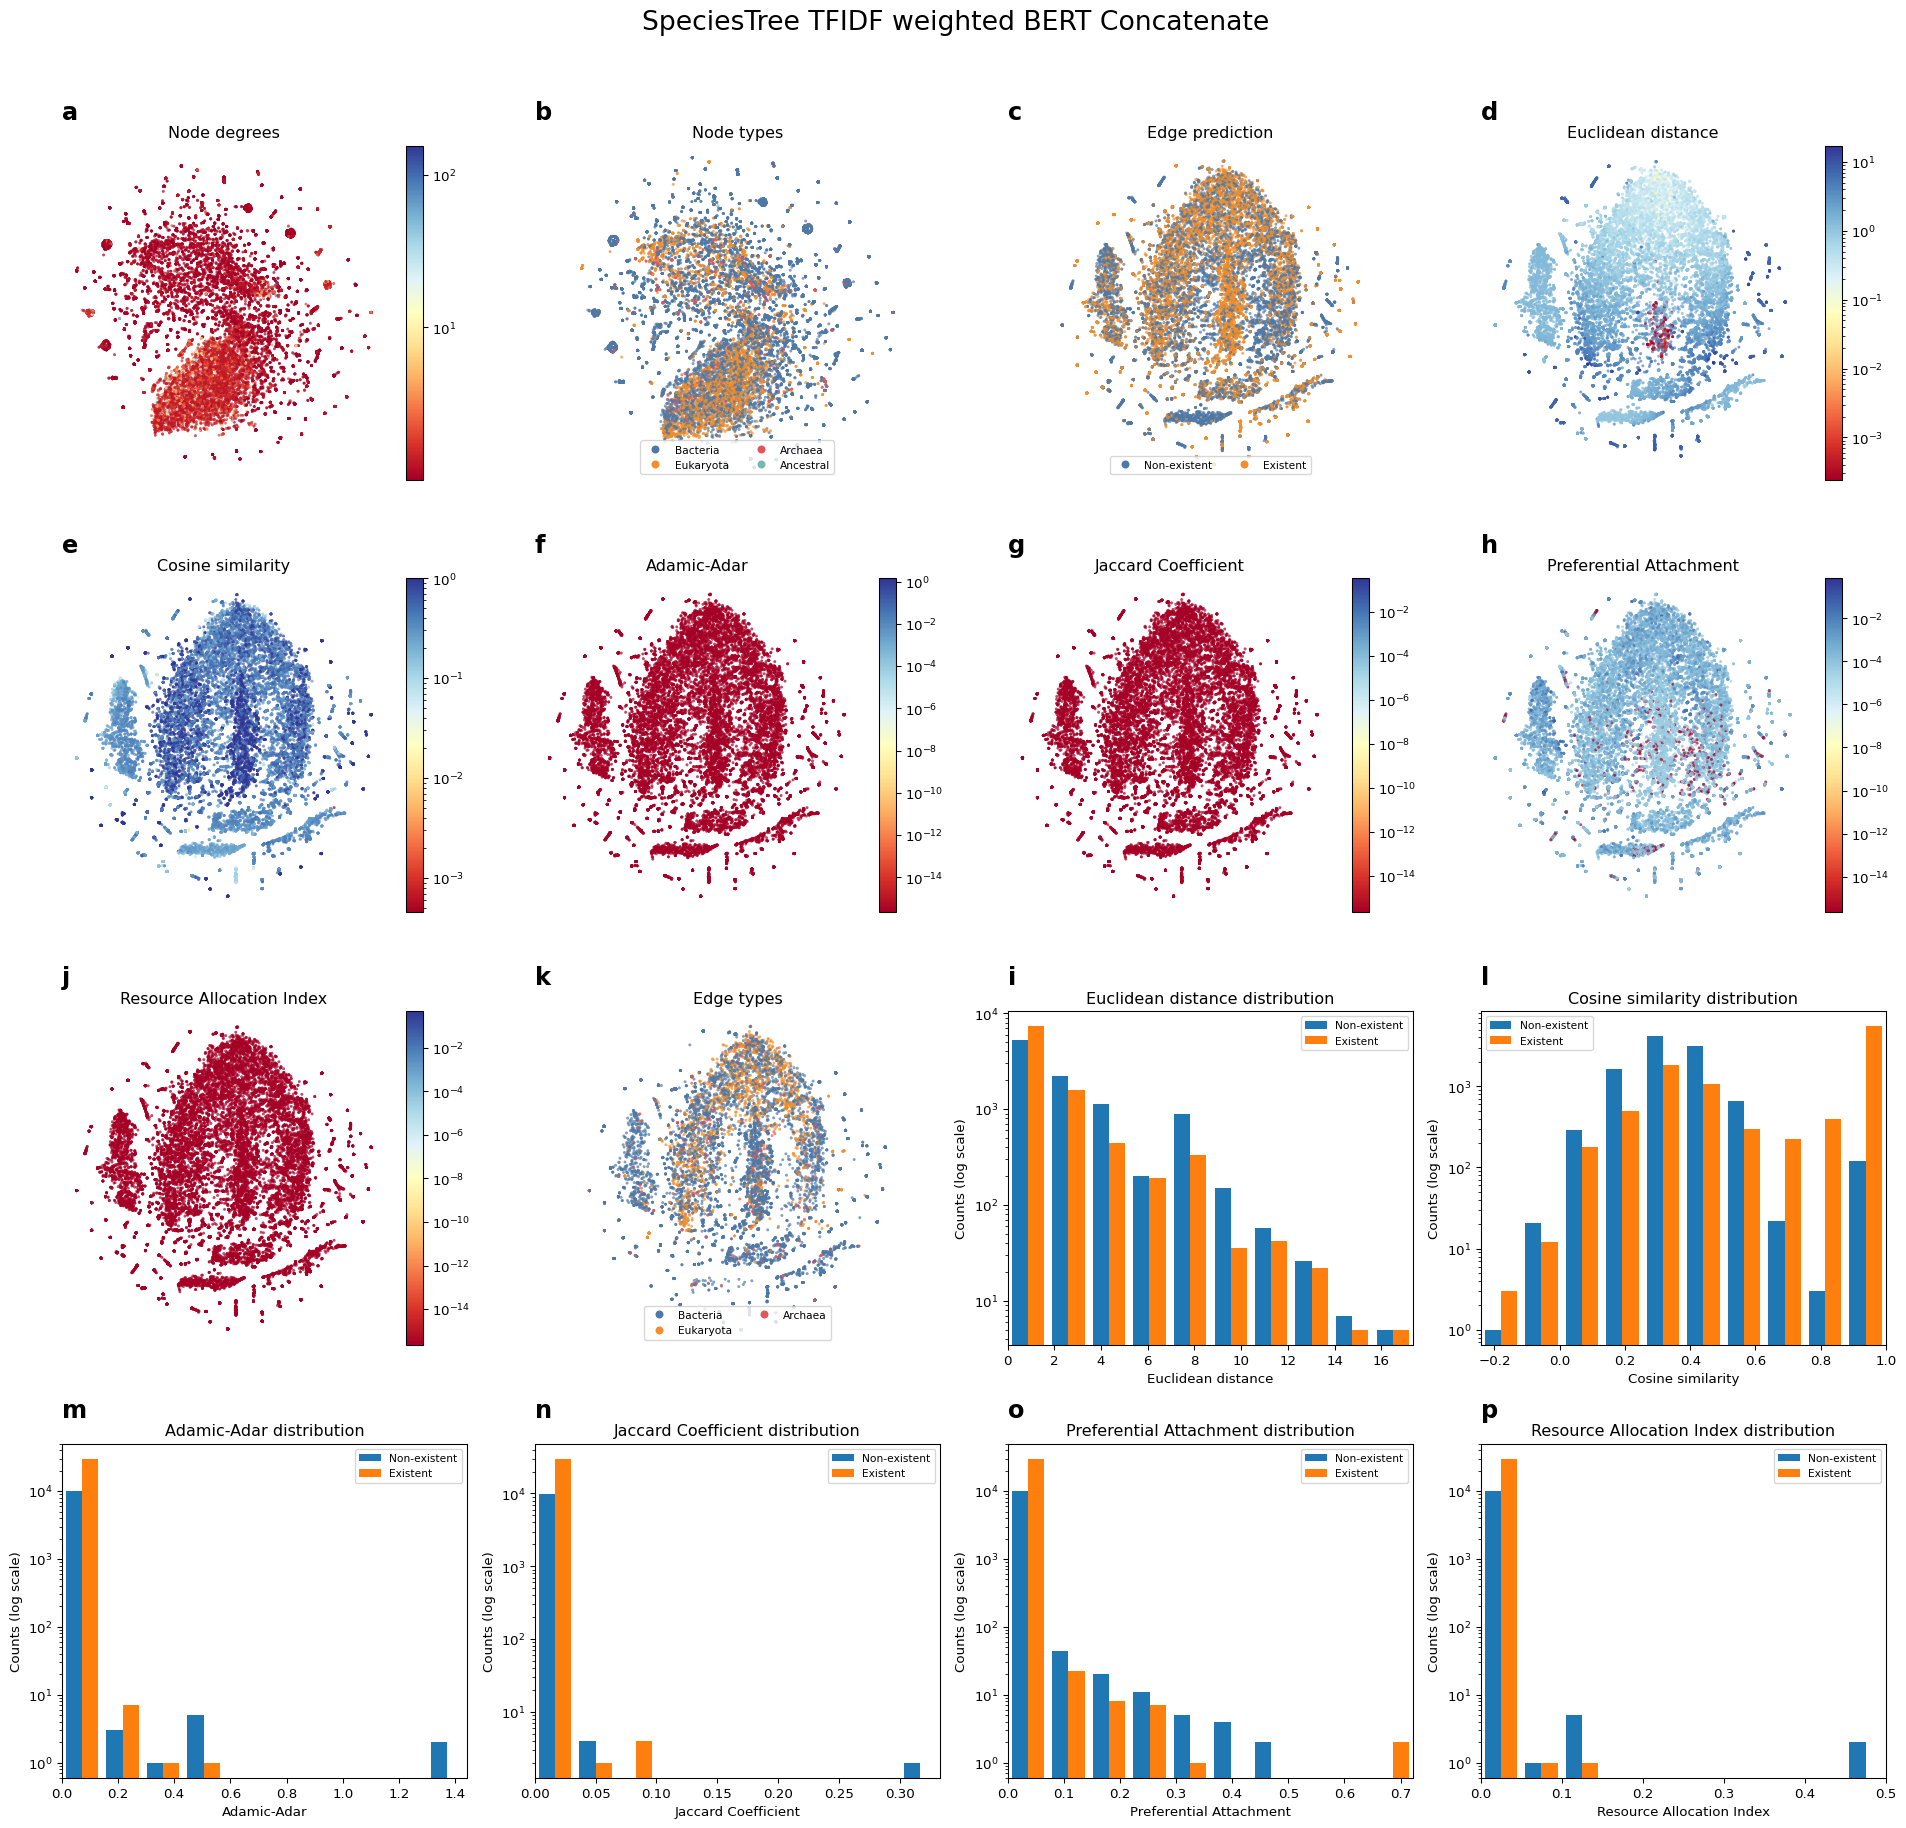

In [72]:
from grape import GraphVisualizer

GraphVisualizer(graph).fit_and_plot_all(embedding)

The features do not seem to match with the graph topology, but the cosine similarity is pretty high! These node descriptions may be useful after all!

## Growing your graph
Finally, now that we have node features, we can grow our very sparse graph!

Let's take a look at the node degree distribution of the original graph, which, again, is a simple tree.

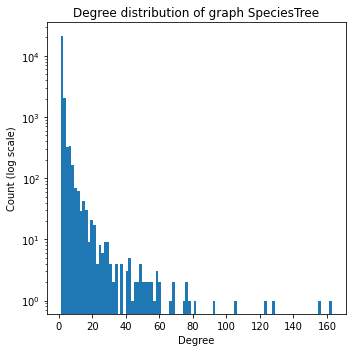

In [73]:
from grape import GraphVisualizer

GraphVisualizer(graph).plot_node_degree_distribution()

We have most nodes within the `10` degree margin, and we want to increase their connectivity. Do note that this is not yet the most efficient implementation, and much of this can be sped up.

**This procedure is currently QUADRATIC and meant to be used only on the very low density areas of a normal graph. A tree is a pathological case where almost all of the graph is low density.**

In [75]:
%%time
new_graph = graph.generate_new_edges_from_node_features(
    # We pass the textual embeddding we have just computed
    features=embedding.values,
    # We will only work on nodes with degree less than 10
    max_degree=10,
    # We want to add 5 new neighbours to all nodes with degree less than 10.
    neighbours_number=5,
    # We will use the COSINE distance, and add the 5 nodes that are closest to
    # the node we are currently working on.
    distance_name="COSINE",
    verbose=True
)

CPU times: user 31min 32s, sys: 4.93 s, total: 31min 37s
Wall time: 2min 45s


We can now plot the updated node degree distribution to see how it changed:

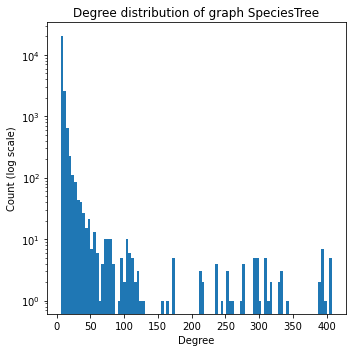

In [76]:
from grape import GraphVisualizer

GraphVisualizer(new_graph).plot_node_degree_distribution()

In the original graph we had:

In [79]:
graph.get_node_degrees_mean(), graph.get_node_degrees_median()

(1.9999187520311992, 1)

In the new graph we have:

In [80]:
new_graph.get_node_degrees_mean(), new_graph.get_node_degrees_median()

(9.487731556711083, 7)

Let's check out the new density of the graph:

In [81]:
new_graph.get_density()

0.0002555275849974561

This is much much denser! Let's now take a look at the graph report!

In [82]:
new_graph

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>SpeciesTree</h2><p class="paragraph">The undirected multigraph SpeciesTree has 24.62K heterogeneous nodes and 116.78K heterogeneous edges. The graph is connected, that is, it is composed of a single connected component that includes all nodes and edges. The RAM requirements for the nodes and edges data structures are 3.63MB and 1.13MB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 6, the maximum node degree is 408, the mode degree is 6, the mean degree is 9.49 and the node degree median is 7.</p><p class="paragraph">The nodes with the highest degree centrality are Candidatus Liberibacter asiaticus (degree 408 and node type Bacteria), Candidatus Latescibacteria (degree 407 and node type Bacteria), Candidatus Blochmannia pennsylvanicus (degree 407 and node type Bacteria), Candidatus Odyssella thessalonicensis (degree 407 and node type Bacteria) and Candidatus Paracaedibacter acanthamoebae (degree 406 and node type Bacteria).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has 4 node types, which are Bacteria (19.13K nodes, 77.72%), Eukaryota (4.50K nodes, 18.27%), Archaea (987 nodes, 4.01%) and Ancestral. The RAM requirement for the node types data structure is 1.28MB.</p><h4 style="margin: 1em 0 0 0;">Singleton node types</h4><p class="paragraph">Singleton node types are node types that are assigned exclusively to a single node, making the node type relatively meaningless, as it adds no more information than the node name itself. The graph contains a singleton node type, which is Ancestral (node cellular organisms (degree 8 and node type Ancestral)).</p><h3 style="margin: 1em 0 0 0;">Edge types</h3><p class="paragraph">The graph has 3 edge types, which are Bacteria (38.26K edges, 77.72%), Eukaryota (8.99K edges, 18.27%) and Archaea (1.97K edges, 4.01%). The RAM requirement for the edge types data structure is 934.57KB.</p><h4 style="margin: 1em 0 0 0;">Unknown edge types</h4><p class="paragraph">Edges with unknown edge types are edges with a edge type that was not provided during the creation of the graph, which may be desired as the output of a edge-label holdout. The graph contains 184320 edges with unknown edge type, which are edge between "Bacteria (degree 23 and node type Bacteria)" and "[Cellvibrio] gilvus ATCC 13127 (degree 6 and node type Bacteria)" with unknown edge type, edge between "Azorhizobium (degree 17 and node type Bacteria)" and "Cellvibrio (degree 21 and node type Bacteria)" with unknown edge type, edge between "Azorhizobium (degree 17 and node type Bacteria)" and "Buchnera aphidicola (Myzus persicae) (degree 11 and node type Bacteria)" with unknown edge type, edge between "Azorhizobium (degree 17 and node type Bacteria)" and "Buchnera aphidicola str. APS (Acyrthosiphon pisum) (degree 11 and node type Bacteria)" with unknown edge type, edge between "Azorhizobium (degree 17 and node type Bacteria)" and "Buchnera aphidicola (Acyrthosiphon pisum) 

Let's compare how a simple topological embedding method such as [First-order LINE](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Using_First-order_LINE_to_embed_Cora.ipynb).

First, let's visualize using [TSNE](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Multiple%20Species%20Tree%20visualizations.ipynb) the first-order LINE embedding of the original sparse graph:

In [70]:
from grape import GraphVisualizer

GraphVisualizer(graph).fit_and_plot_all("First-order LINE")

While the LINE embedding seems to be very accurately matching the graph topology **BEWARE!** This is evaluated on the training graph, and that is just overfitting. Note how all edge prediction metrics are useless, for instance the jaccard index does not predict any better than random chance, and there is no predictions for the node types-

And the densified version:

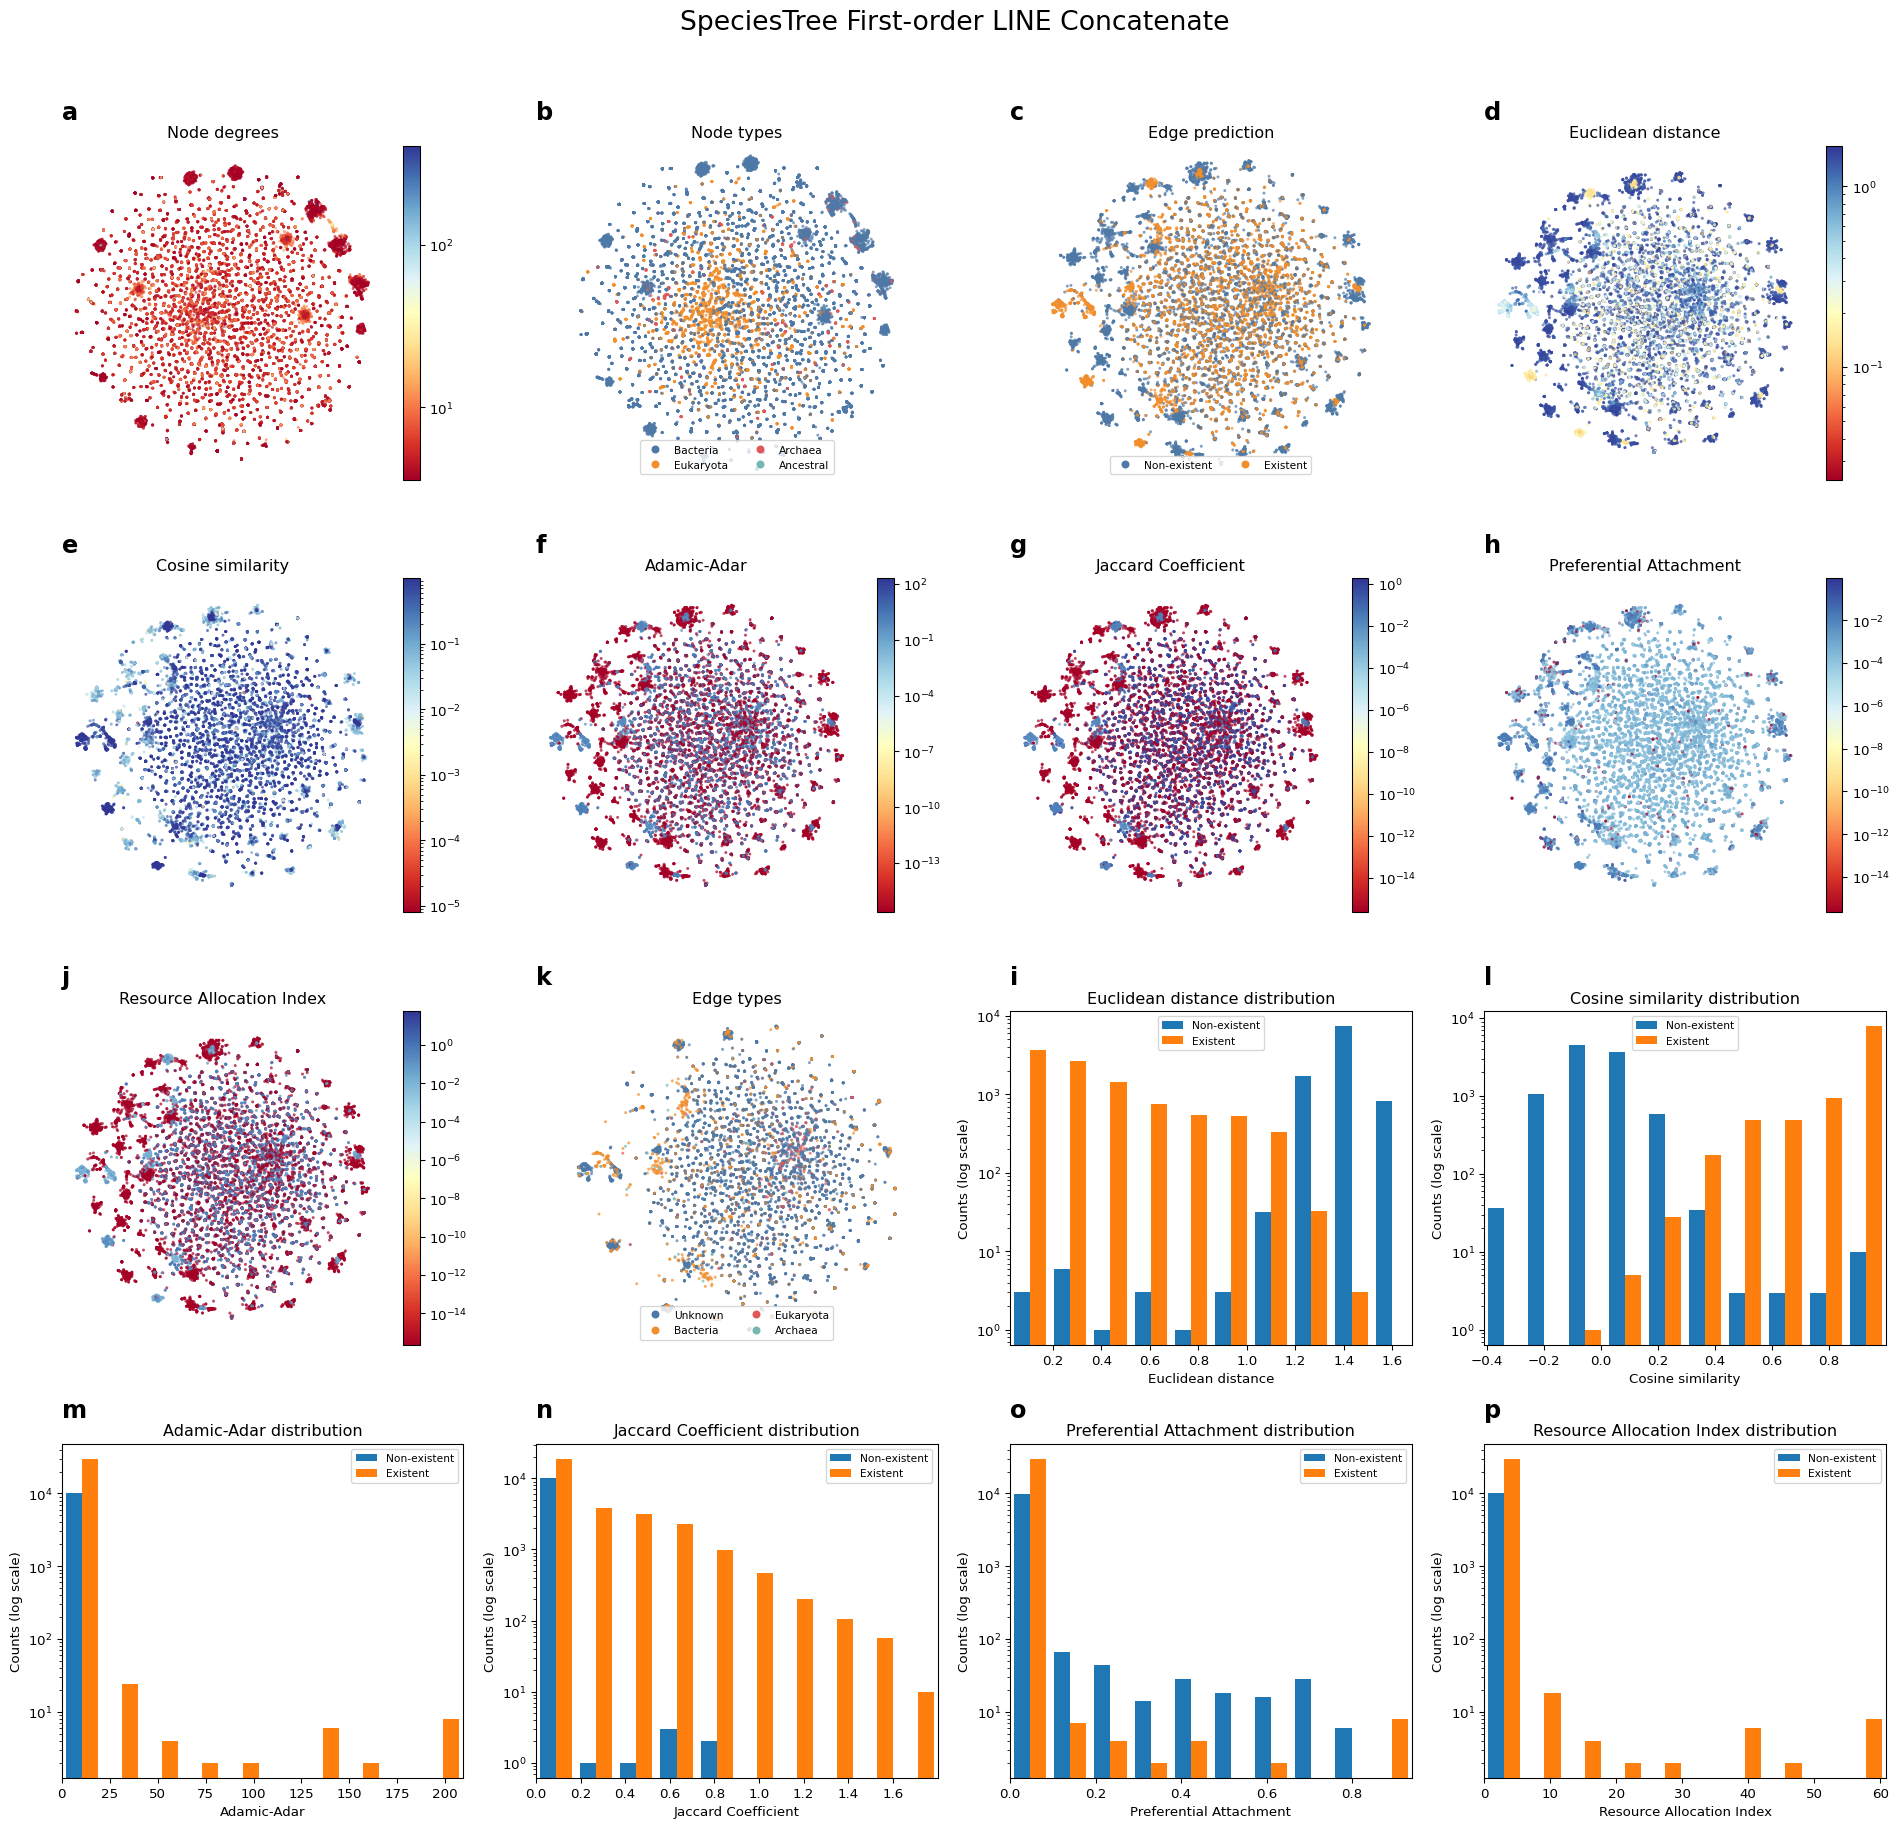

In [83]:
from grape import GraphVisualizer

GraphVisualizer(new_graph).fit_and_plot_all("First-order LINE")

Now we are talking! By including this additional knowledge, we now have signal from several topological metrics! Still, these performance mean very little when evaluated directly on the training graph.

To properly evaluate them, [we need to use graph holdouts, which I describe in this previous tutorial](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Graph_holdouts_using_GRAPE.ipynb).

## Conclusion
This tutorial showcased the process of graph densification using Wikipedia, SciBERT, and GRAPE. By growing a graph from an initial sparse tree graph, the tutorial demonstrated how to mine textual features from Wikipedia and embed them using a pre-trained SciBERT model. This process can be executed on any set of node features to improve the density of a graph and, thus, improve the predictions of graph ML models. This tutorial can be scaled to larger graphs by downloading Wikipedia and creating a reverse index for faster querying.

There are surely several different heuristics one may want to use while growing their graph, but even this extremely simple one is useful to increase connectivity even in desperate situations.

Do consider [following me on LinkedIn](https://www.linkedin.com/in/lucacappelletti94/) for more tutorials, and do [star the GRAPE repository](https://github.com/AnacletoLAB/grape)!